# Car Insurance Claim Prediction

В этом проекте исследуется поведение клиентов страховой компании, выдающей автомобильные страховки. На основании социально-демографических данных, исторических данных о пользовании автомобилем и других предоставленных данных о клиенте определяется факт и вероятность требования страховой выплаты. 

## 1. Загрузка и первичный анализ данных

В этом проекте используются данные, предоставленные платформой Kaggle: [Car Insurance Data](https://www.kaggle.com/sagnik1511/car-insurance-data).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

cmap = sns.color_palette('muted')

In [2]:
data = pd.read_csv('./data/Car_Insurance_Claim.csv')

In [3]:
data.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


Целевая переменная 'OUTCOME' - 1, если клиенту была выплачена страховка, иначе - 0.

Данные содержат следующий набор признаков про каждого клиента:
- 'ID' - уникальный номер (id) клиента
- 'AGE' - возрастная категория
- 'GENDER' - пол
- 'RACE' - раса
- 'DRIVING_EXPERIENCE' - опыт вождения
- 'EDUCATION' - образование
- 'INCOME' - уровень дохода
- 'CREDIT_SCORE' - кредитный скор
- 'VEHICLE_OWNERSHIP' - владение транспортным средством 
- 'VEHICLE_YEAR' - год транспортного средства
- 'MARRIED' - семейное положение
- 'CHILDREN' - наличие детей
- 'POSTAL_CODE' - почтовый код
- 'ANNUAL_MILEAGE' - годовой пробег
- 'VEHICLE_TYPE' - тип транспортного средства
- 'SPEEDING_VIOLATIONS' - количество случаев превышения скорости
- 'DUIS' - количество случаев вождения в нетрезвом виде
- 'PAST_ACCIDENTS' - количество несчастных случаев

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

Итого, в датасете есть 10000 наблюдений и 19 колонок: целевая переменная ('OUTCOME'), колонка с id каждого наблюдения ('ID') и 17 признаков. При этом, пропуски есть только в двух из них: в кредитном скоре и годовом пробеге. Так как при получении страховки клиентам присваивают скор и у их транспортного средства должен быть хотя бы нулевой показатель годового пробега, то значит пропуски случайные, не несущие в себе особого смысла, и являются следствием некачественного заполнения базы данных.

## 2. EDA

В датасете есть категориальные и количественные признаки. Проанализируем каждый из них, посмотрим на распределение, заполним пропуски там, где потребуется.

Сначала проверим, что уникальный идентификатор клиента 'ID' действительно уникален и не повторяется.

In [5]:
if len(data['ID'].unique()) == data.shape[0]:
    print('ID уникален, повторов нет')
else:
    print('ID не уникален, нужен доп. анализ')

ID уникален, повторов нет


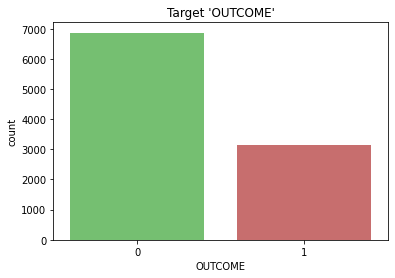

In [6]:
sns.countplot('OUTCOME', data=data, palette=[cmap[2], cmap[3]], order=[0, 1])
plt.title("Target 'OUTCOME'")
plt.show()

Целевая переменная 'OUTCOME' содержит 31% наблюдений первого класса.

### Категориальные признаки

In [7]:
cat_features = ['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
                'VEHICLE_YEAR', 'POSTAL_CODE', 'VEHICLE_TYPE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN']

In [8]:
data['OUTCOME'] = data['OUTCOME'].astype(int)

In [9]:
def plot(data, column, order=None, location='best'):
    """
    This function plots two histograms.
    First histogram displays the distribution of one feature.
    Second histograms displays the distribution of one feature in the cut of target OUTCOME.
    """
    title = column.capitalize().replace('_', ' ')
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    sns.countplot(x=column, data=data, ax=ax1, palette=[cmap[7]], order=order)
    ax1.set_title(title)
    sns.countplot(x=column, hue='OUTCOME', data=data, ax=ax2, palette=[cmap[2], cmap[3]], order=order)
    ax2.set_title(f'{title} and Outcome')
    plt.legend(loc=location, title='OUTCOME')
    plt.show()

#### Age

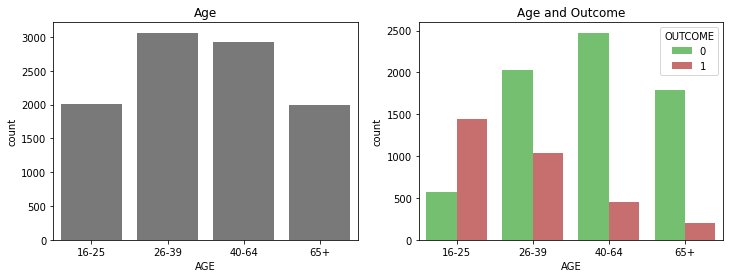

In [10]:
plot(data, 'AGE', order=['16-25', '26-39', '40-64', '65+'])

Признак 'AGE' содержит 4 возрастные категории: '16-25', '26-39', '40-64', '65+'. Категории распределены довольно равномерно. Также видно нисходящий тренд в количестве выданных страховок с увеличением возрастной группы, то есть чем водитель старше, тем меньше вероятность, что ему потребуется выплачивать страховку. Также заметим, что в возрастной категории водителей от 16 до 25 лет соотношение тех кому пришлось выплатить страховку к тем кому она не была выплачена составляет примерно 3:1. То есть если в страховую компанию придет клиент в возрасте от 16 до 25 лет, то с вероятностью 75% нам придется выплачивать ему страховку.

#### Gender

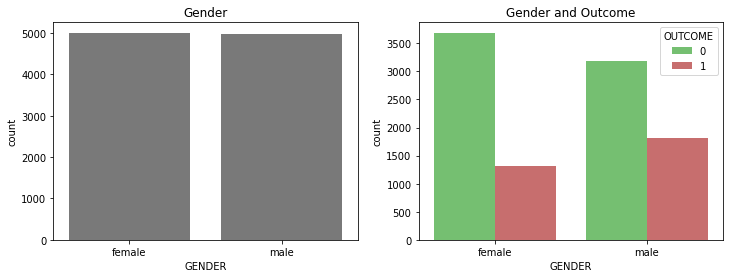

In [11]:
plot(data, 'GENDER')

Видно, что по полу клиенты распределены равномерно, то есть женщины и мужчины берут автомобильную страховку одинаково часто. Кроме того, можно заметить интересный факт: мужчинам чаще приходится выплачивать страховку.

#### Race

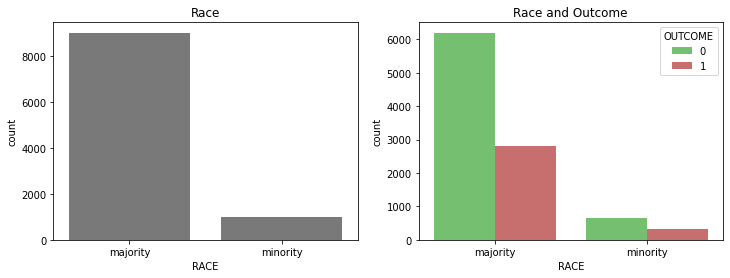

In [12]:
plot(data, 'RACE')

В данных есть явный дисбаланс клиентов по расе: подавляющее большинство клиентов относится к мажоритарному классу. При этом, распределение количества выплаченных и невыплаченных страховок для обеих категорий примерно одинаково.

#### Driving experience

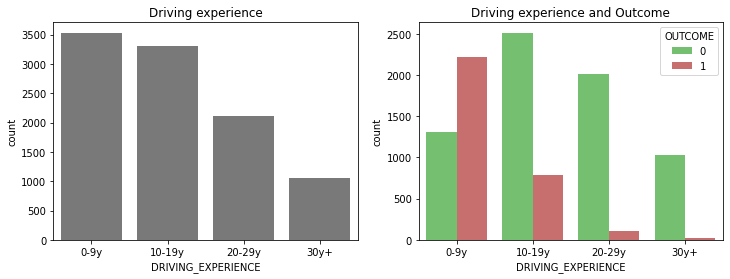

In [13]:
plot(data, 'DRIVING_EXPERIENCE')

Видно, что водителей со стажем больше 30 лет в выборке меньше всего, остальные группы распределены довольно равномерно. Также среди водителей со стажем больше 30 лет почти нет тех, кому приходится выплачивать страховку, и в целом наблюдается нисходящий тренд, что водителям с большим стажем реже приходится выплачивать страховку. Очень примечательна группа водителей со стажем меньше 9 лет, из которых больше чем половине приходится выплачивать страховку.

#### Education

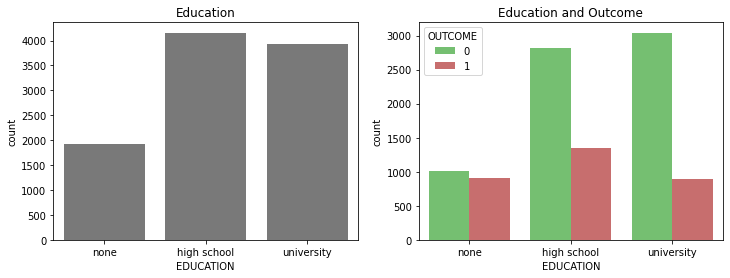

In [14]:
plot(data, 'EDUCATION', order=['none', 'high school', 'university'])

Видно, что видители с образованием 'high school' и 'university' берут страховку примерно одинаково часто, выплачивать страховку им также приходится одинаково часто.

Очень важным наблюдением является наличие категории 'none', что может означать либо плохую заполненность данных, либо действительно отстутствие какого-либо образования. Само отсутствие образования может означать либо, что человек еще не закончил школу и не имеет никакого официального статуса, либо что человек уже достаточно взрослый и не имеет образования или имеет образование, не относящееся к этим категориям, например, колледж.

Во-первых, обратим внимание, что распределение выплат/невыплат в этой категории довольно равномерное в отличие от других категорий. Это скорее свидетельствует, что это не случайное отсутствие данных или плохое их заполнение, а некая категория, отличная от других.

Во-вторых, посмотрим на распределение возраста у клиентов с образованием 'none'. Это должно помочь понять значение данной категории.

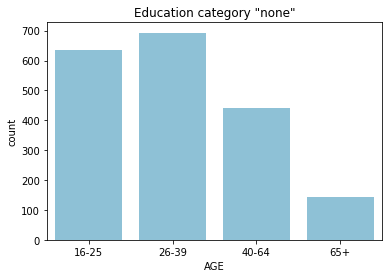

In [15]:
sns.countplot('AGE', data=data[data['EDUCATION'] == 'none'], palette=[cmap[-1]],
              order=['16-25', '26-39', '40-64', '65+'])
plt.title('Education category "none"')
plt.show()

Видно, что в категорию с образованием 'none' попадают клиенты из всех возрастных групп. Нет явного перекоса в одну из категорий.

Таким образом, это данные говорят о том, что пропуски могут быть вызваны любой из вышеперечисленных причин: это могут быть школьники, не закончившие образование, взрослые люди без образования или же просто некачественное заполнение данных.

В дальнейшем анализе, мы не будем заменять категорию 'none' в образовании на какую-то другую и оставим её как самодостаточную.

#### Income

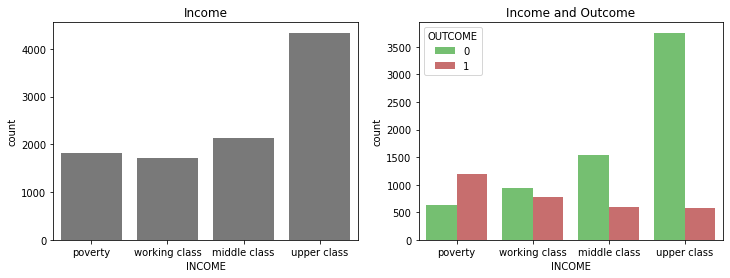

In [16]:
plot(data, 'INCOME', order=['poverty', 'working class', 'middle class', 'upper class'])

Видно, что количество клиентов с доходом 'upper class' примерно в 2 раза больше, чем клиентов любого другого типа доходов. При этом, остальные категории распределены довольно равномерно. Также видно, что количество выплат по страховкам уменьшается с уровнем дохода, а также клиентам с доходом категории 'working class' и 'poverty' гораздо чаще других приходится выплачивать страховку: в 'working class' примерно половине требуются выплаты по страховке, а в 'poverty' примерно двум третям.

#### Vehicle year

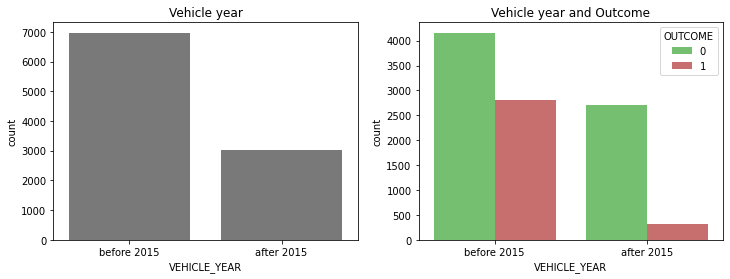

In [17]:
plot(data, 'VEHICLE_YEAR', order=['before 2015', 'after 2015'])

Большая часть автомобилей была выпущена до 2015 года, и процент выплат по страховкам для клиентов на таких автомобилях значительно выше, около 40%.

#### Postal code

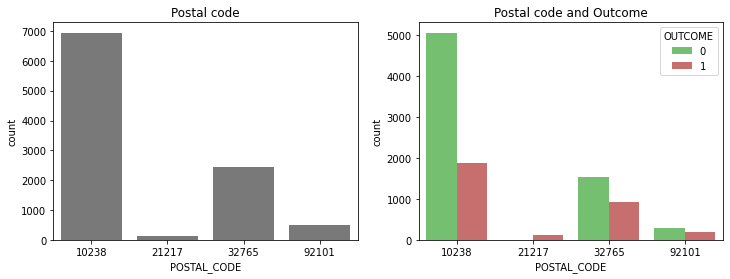

In [18]:
plot(data, 'POSTAL_CODE')

Сразу отметим, что в данных присутствуют клиенты лишь с 4 регионов, что может говорить о нерепрезентативности выборки по всей стране. Распределение численности клиентов в каждом регионе сильно неравномерное. В регионах 10238 и 3756 доля выплат по страховкам не очень большая, в регионе 92101 доля выплат почти 50%, а в регионе 21217 в 100% случаев понадобилась выплата по страховке.

#### Vehicle type

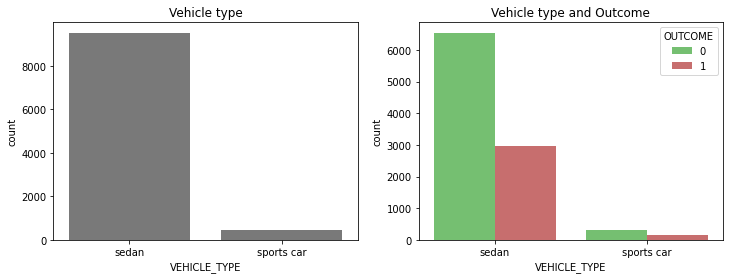

In [19]:
plot(data, 'VEHICLE_TYPE')

Большая часть автомобилей - седан, а процент выплат по страховкам для клиентов и седанов и спортивных машин примерно одинаковый.

#### Vehicle ownership

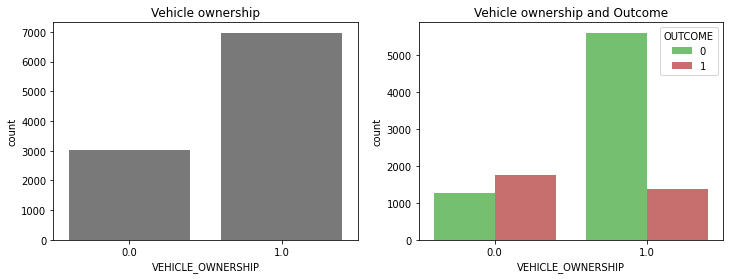

In [20]:
plot(data, 'VEHICLE_OWNERSHIP')

Владельцы собственных автомобилей чаще обращаются за страховкой, чем клиенты не являющиеся владельцами автомобиля, на который оформляется страховка. Также владельцам гораздо реже приходится выплачивать страховку, чем не владельцам, более чем половине из которых приходится выплачивать страховку.

#### Married

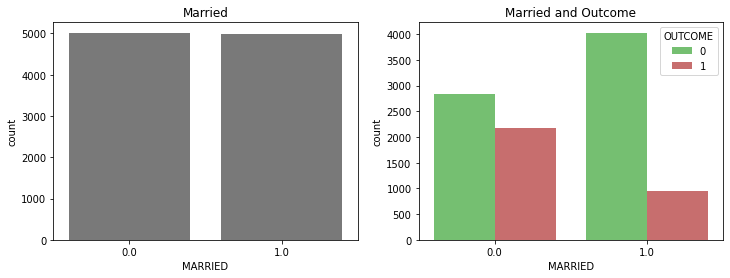

In [21]:
plot(data, 'MARRIED')

В выборке одинаковое количество людей в браке и не в браке, при этом, клиентам, не состоящим в браке, приходится выплачивать страховку чаще.

#### Children

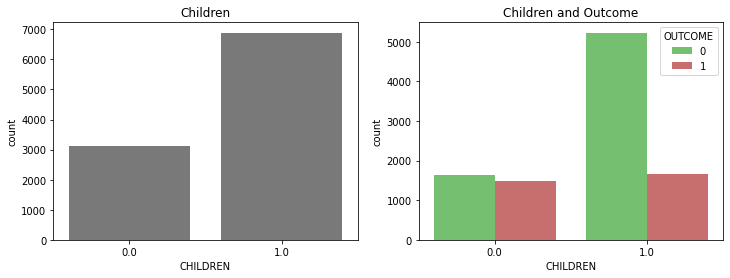

In [22]:
plot(data, 'CHILDREN')

В выборке большая часть клиентов имеет детей, при этом, клиентам, которые не имеют детей, приходится чаще выплачивать страховку, примерно в половине случаев.

In [23]:
pd.crosstab(data.CHILDREN, data.MARRIED, margins=True).style.background_gradient(cmap='summer_r')

MARRIED,0.0,1.0,All
CHILDREN,,,
0.0,2226,886,3112
1.0,2792,4096,6888
All,5018,4982,10000


Интересно, что среди тех, кто имеет детей, почти половина не состоит в браке. При этом большинство людей в браке имеют детей.

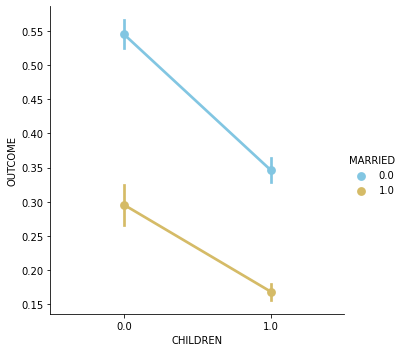

In [24]:
sns.factorplot('CHILDREN', 'OUTCOME', hue='MARRIED', data=data, palette=[cmap[-1], cmap[-2]])
plt.show()

При этом, факт наличия брака оказывает более сильное влияние на аккуратное вождение и отсутствие выплат по страховке, чем факт наличия ребенка. Видно, что для женатых клиентов без детей 'OUTCOME' статистически меньше, чем для неженатых клиентов с детьми.

### Количественные признаки

In [25]:
data.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


#### Credit score

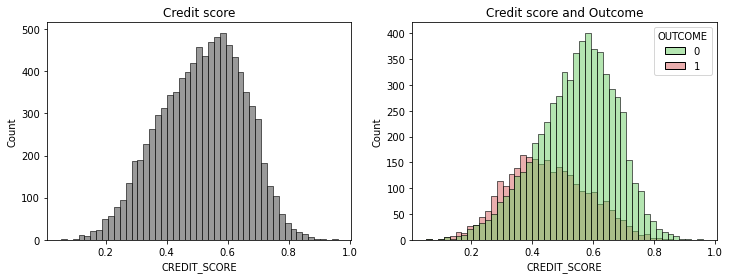

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(x='CREDIT_SCORE', data=data, ax=ax1, color=cmap[7])
ax1.set_title('Credit score')
sns.histplot(x='CREDIT_SCORE', hue='OUTCOME', data=data, ax=ax2, palette=[cmap[2], cmap[3]])
ax2.set_title('Credit score and Outcome')
plt.show()

Пик распределения кредитного скора для 'OUTCOME' 0 в 0.4, для 'OUTCOME' 1 в 0.6, что довольно логично, так как компания чаще выплачивает автомобильную страховку более ненадежным людям, у которых хуже кредитный скор.

#### Annual milleage

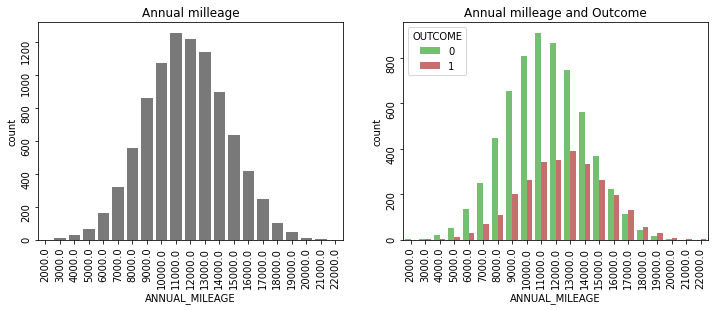

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.countplot('ANNUAL_MILEAGE', data=data, ax=ax1, palette=[cmap[7]])
ax1.set_title('Annual milleage')
ax1.tick_params(labelrotation=90)
sns.countplot('ANNUAL_MILEAGE', hue='OUTCOME', data=data, ax=ax2, palette=[cmap[2], cmap[3]])
ax2.set_title('Annual milleage and Outcome')
ax2.tick_params(labelrotation=90)
plt.show()

Пик распределения годового пробега автомобиля для клиентов с 'OUTCOME' 0 в 11000, для 'OUTCOME' 1 в 13000. Кроме того, среди клиентов, которые больше проезжают, растет доля выплаченных страховок.

#### Speeding violations

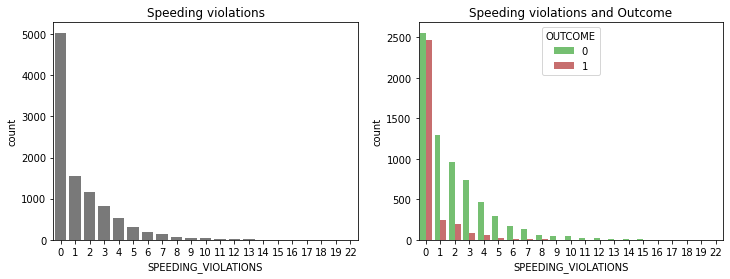

In [28]:
plot(data, 'SPEEDING_VIOLATIONS')

Среди тех, кто не имеет ни одного нарушения скорости, примерно половине приходится выплачивать страховки. При этом, по тем кто имеет нарушения, доля выплат падает.

#### DUIs

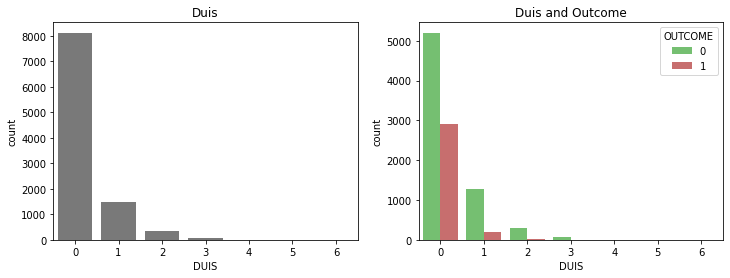

In [29]:
plot(data, 'DUIS', location='upper right')

Среди тех клиентов, кто не имеет случаев вождения в нетрезвом виде, наиболее большой процент тех, кому выплачивают страховки.

#### Past accidents

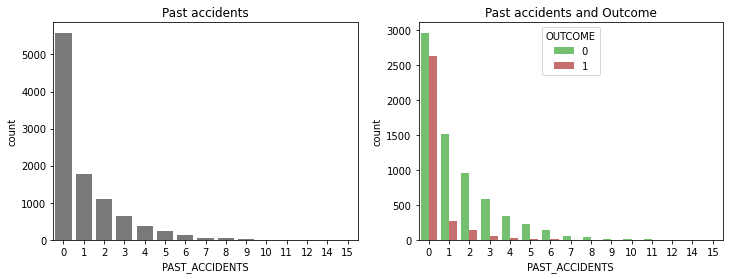

In [30]:
plot(data, 'PAST_ACCIDENTS')

Среди тех клиентов, кто не имеет предыдущих несчастных случаев, наиболее большой процент тех, кому выплачивают страховки, равный почти 50%.

In [31]:
# Заполним пропуски медианными значениями
data['CREDIT_SCORE'].fillna(data['CREDIT_SCORE'].median(), inplace = True)
data['ANNUAL_MILEAGE'].fillna(data['ANNUAL_MILEAGE'].median(), inplace = True)

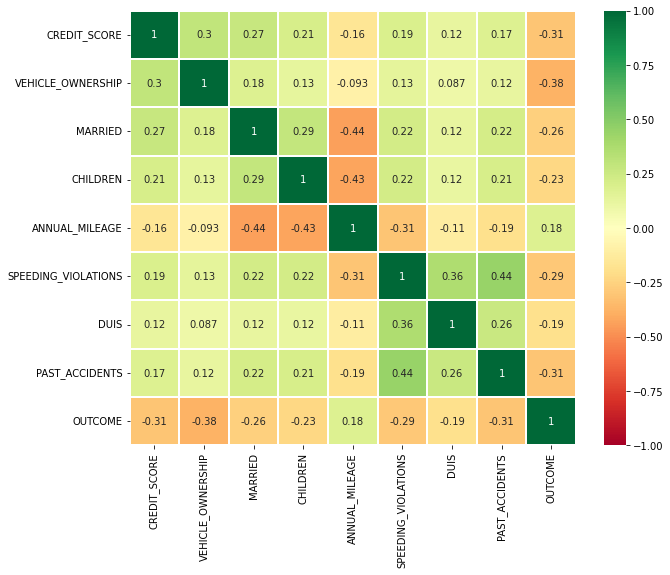

In [32]:
sns.heatmap(data.drop(columns=['ID', 'POSTAL_CODE']).corr(),
            vmin=-1, vmax=1, annot=True, cmap='RdYlGn', linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

- Целевая переменная 'OUTCOME' отрицательно коррелирует с признаком 'VEHICLE_OWNERSHIP'. То есть, клиенты не владеющие данным транспортным средством вероятнее воспользуются страховкой.
- Признак количество нарушений скорости ('SPEEDING_VIOLATIONS') положительно коррелирует с количеством прошлых аварий ('PAST_ACCIDENTS') и с количеством вождений за рулем в нетрезвом виде ('DUIS') и отрицательно коррелирует с годовым пробегом автомобиля ('ANNUAL_MILEAGE')
- Годовой пробег ('ANNUAL_MILEAGE') отрицательно коррелирует с фактом брака ('MARRIED') и с фактом наличия детей ('CHILDREN')

**Основные Выводы**

- Баланс классов целефой переменной востанавливать не нужно с помощью under- и oversampling методов.
- Можно выделить группы, в которых очень велика доля клиентов, которым страховая компания выплачивает страховки (около 50% и больше): люди от 16 до 25 лет, водители со стажем от 0 до 9 лет, клиенты с образованием указанным как 'none', люди с доходом из классов 'working class' и 'poverty', клиенты с почтовыми кодами  92101 и 21217, клиенты, не являющиеся владельцами автомобиля, на который оформляется страховка, клиенты, не имеющие детей, а также клиенты с кредитным скором ниже 0.4, с годовым пробегом больше 16000, не имеющие превышений скорости или предыдущих происшествий.
- По матрице корреляций все попарные зависимости логичны и непротиворечивы. Единственное, что может показаться удивительным и по матрице корреляций и по анализу переменных, что клиенты не превышающие скорость, не водящие автомобиль в нетрезвом виде и не имеющие прошлых происшествий вероятнее пользуются выплатами по страховке, чем водящие машину менее аккуратно. Но вероятнее всего этот факт объясняется тем, что люди, имеющие какие-либо нарушения в прошлом реже попадают под страховой случай и поэтому реже получают выплаты по страховке.
- Из плохого заполнения признаков можно обратить внимание на категорию 'none' в образовании, которая скорее всего объединяет в себе несколько разных подкатегорий. В остальном все переменные качественно заполнены, пропуски есть только в двух признаках и составляют менее 10%.

Таким образом, набор данных полностью удовлетворяет нашим ожиданиям. Данные являются достаточными и не противоречивыми. Данные готовы к построению модели на них.

## 3. Baseline

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [34]:
X, X_test, y, y_test = train_test_split(data.drop(columns=['OUTCOME']), data['OUTCOME'],
                                                    test_size=1000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=2000, random_state=42)

In [35]:
encode_features = ['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
                   'VEHICLE_YEAR', 'POSTAL_CODE', 'VEHICLE_TYPE']
num_features = ['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'ANNUAL_MILEAGE',
                'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']

In [36]:
encoder = OneHotEncoder(drop='if_binary', sparse=False, handle_unknown='error')
X_train_enc = encoder.fit_transform(X_train[encode_features])
X_val_enc = encoder.transform(X_val[encode_features])
X_test_enc = encoder.transform(X_test[encode_features])

X_train_enc = pd.DataFrame(X_train_enc, columns=encoder.get_feature_names(encode_features), index=X_train.index)
X_val_enc = pd.DataFrame(X_val_enc, columns=encoder.get_feature_names(encode_features), index=X_val.index)
X_test_enc = pd.DataFrame(X_test_enc, columns=encoder.get_feature_names(encode_features), index=X_test.index)

X_train_new = pd.concat([X_train[num_features], X_train_enc], axis=1)
X_val_new = pd.concat([X_val[num_features], X_val_enc], axis=1)
X_test_new = pd.concat([X_test[num_features], X_test_enc], axis=1)

In [37]:
classifiers = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(random_state=42)),
    "Linear SVM": make_pipeline(StandardScaler(), SVC(C=0.05, kernel='linear', probability=True, random_state=42)),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=8, min_samples_leaf=5,random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, iterations=700, depth=6,  verbose=False)
}

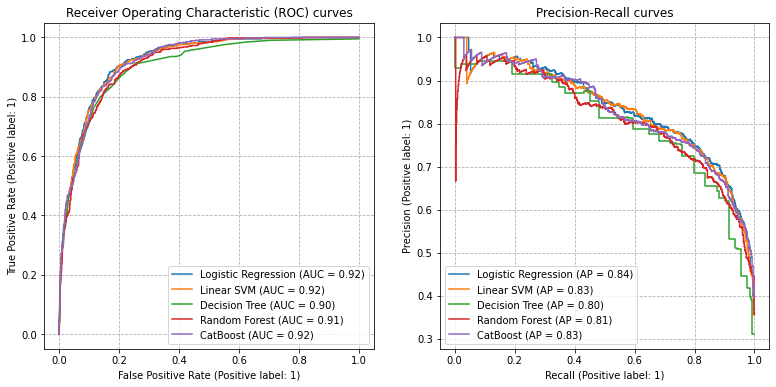

In [38]:
fig, [ax_roc, ax_pr] = plt.subplots(1, 2, figsize=(13, 6))
table = []

for name, clf in classifiers.items():
    clf.fit(X_train_new, y_train)

    plot_roc_curve(clf, X_val_new, y_val, ax=ax_roc, name=name)
    plot_precision_recall_curve(clf, X_val_new, y_val, ax=ax_pr, name=name)
    
    y_pred = clf.predict(X_val_new)
    a = accuracy_score(y_val, y_pred)
    p = precision_score(y_val, y_pred)
    r = recall_score(y_val, y_pred)
    f = f1_score(y_val, y_pred)
    ra = roc_auc_score(y_val, y_pred)
    table.append([a, p, r, f, ra])
    
    
ax_roc.set_title('Receiver Operating Characteristic (ROC) curves')
ax_pr.set_title('Precision-Recall curves')

ax_roc.grid(linestyle='--')
ax_pr.grid(linestyle='--')

plt.legend()
plt.show()

In [39]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score']
pd.DataFrame(table, index=classifiers.keys(), columns=metrics)

,accuracy,precision,recall,f1_score,roc_auc_score
Logistic Regression,0.8520,0.780822,0.730769,0.754967,0.818873
Linear SVM,0.8530,0.780612,0.735577,0.757426,0.820913
Decision Tree,0.8410,0.759322,0.717949,0.738056,0.807376
Random Forest,0.8415,0.756260,0.725962,0.740801,0.809928
CatBoost,0.8475,0.767169,0.733974,0.750205,0.816478


По таблице с моделями видно, что метрике recall, которая наиболее важна с точки зрения бизнеса, лучшее качество показала модель Linear SVM. По остальным метрикам эта модель либо лучше либо уступает не более чем на 0.02. Поэтому, в качестве финальной модели мы выбираем Linear SVM.

In [40]:
table_svc = []

for X, y in zip([X_train_new, X_val_new, X_test_new], [y_train, y_val, y_test]):
    y_pred = classifiers["Linear SVM"].predict(X)
    
    a = accuracy_score(y, y_pred)
    p = precision_score(y, y_pred)
    r = recall_score(y, y_pred)
    f = f1_score(y, y_pred)
    ra = roc_auc_score(y, y_pred)
    table_svc.append([a, p, r, f, ra])

In [41]:
pd.DataFrame(table_svc, index=['Train', 'Validation', 'Test'], columns=metrics)

,accuracy,precision,recall,f1_score,roc_auc_score
Train,0.857857,0.783064,0.753318,0.767903,0.829307
Validation,0.853000,0.780612,0.735577,0.757426,0.820913
Test,0.848000,0.796552,0.712963,0.752443,0.812842


**Вывод**

Таким образом, данные позволили успешно построить бейзлайн. Лучше всего себя показала модель Linear SVM	с качеством в 0.752 recall на тестовой выборке, которая была отложена изначально и не использовалась ни при обучении, ни при валидации.

# Stacking
Соберем все предложенные модели вместе, чтобы улучшить качество предсказания

In [42]:
import xgboost as xgb
from typing import List
from sklearn import clone
from sklearn.model_selection import cross_val_predict

In [43]:
class MetaFeatureEstimator:
    def __init__(self, estimators: List, meta_estimator):
        self.estimators = [clone(estimator) for estimator in estimators]
        self.meta_estimator = clone(meta_estimator)
        
    def fit(self, x: pd.DataFrame, y: pd.DataFrame):
        x_new = pd.DataFrame({f'{estimator}_{i}': cross_val_predict(estimator, x , y, n_jobs=1, method='predict_proba')[:,1] for i, estimator in enumerate(self.estimators)})
        for estimator in self.estimators:
            estimator.fit(x,y)
        
        self.meta_estimator.fit(x_new, y)
        
        return self
    
    def predict_proba(self, x: pd.DataFrame):
        x_new = pd.DataFrame({f'{estimator}_{i}': estimator.predict_proba(x)[:,1] for i, estimator in enumerate(self.estimators)})
        return self.meta_estimator.predict_proba(x_new)       

In [44]:
meta_model = MetaFeatureEstimator(list(classifiers.values()), LogisticRegression(random_state=42)).fit(X_train_new, y_train.values)

In [45]:
pred_val = meta_model.predict_proba(X_val_new)[:,1]

In [46]:
# Подбор порога для максимизации recall
pred_stack = np.where(pred_val > 0.2, 1, 0)

In [47]:
a = accuracy_score(y_val, pred_stack)
p = precision_score(y_val, pred_stack)
r = recall_score(y_val, pred_stack)
f = f1_score(y_val, pred_stack)
ra = roc_auc_score(y_val, pred_stack)

In [48]:
pd.DataFrame([a, p, r, f, ra], index=metrics)

,0
accuracy,0.837500
precision,0.682987
recall,0.894231
f1_score,0.774462
roc_auc_score,0.853002


С порогом классификации 20% метрика качества recall дошла до 0.894, при том что остальные метрики качества не сильно снизились.

# Валидация

#### Проверим модель на нескольких выборках на устойчивость предсказания

In [49]:
from sklearn.model_selection import KFold

In [50]:
kf = KFold(n_splits=5, shuffle=True)

In [51]:
X, y = data.drop(columns=['OUTCOME']), data['OUTCOME']

In [52]:
result_kf = pd.DataFrame()
for train_index, val_index in kf.split(X):
    X_train_kf, X_val_kf = X.iloc[train_index], X.iloc[val_index]
    y_train_kf, y_val_kf = y.iloc[train_index], y.iloc[val_index]
    
    X_train_enc = encoder.fit_transform(X_train_kf[encode_features])
    X_val_enc = encoder.transform(X_val_kf[encode_features])
    X_train_enc = pd.DataFrame(X_train_enc, columns=encoder.get_feature_names(encode_features), index=X_train_kf.index)
    X_val_enc = pd.DataFrame(X_val_enc, columns=encoder.get_feature_names(encode_features), index=X_val_kf.index)
    X_train_kf_new = pd.concat([X_train_kf[num_features], X_train_enc], axis=1)
    X_val_kf_new = pd.concat([X_val_kf[num_features], X_val_enc], axis=1)
    
    meta_model_kf = MetaFeatureEstimator(list(classifiers.values()), LogisticRegression(random_state=12)).fit(X_train_kf_new, y_train_kf.values)
    pred_kf = meta_model_kf.predict_proba(X_val_kf_new)[:,1]
    pred_kf = np.where(pred_kf > 0.2, 1, 0)
    a = accuracy_score(y_val_kf, pred_kf)
    p = precision_score(y_val_kf, pred_kf)
    r = recall_score(y_val_kf, pred_kf)
    f = f1_score(y_val_kf, pred_kf)
    ra = roc_auc_score(y_val_kf, pred_kf)
    result_kf = pd.concat([result_kf, pd.DataFrame([a,p,r,f,ra])], axis=1)

In [53]:
result_kf.index = metrics
result_kf.columns = np.arange(1,6)
result_kf

,1,2,3,4,5
accuracy,0.826500,0.855000,0.831000,0.821500,0.818000
precision,0.671199,0.723650,0.660714,0.671133,0.657419
recall,0.870192,0.882445,0.912829,0.863636,0.872000
f1_score,0.757851,0.795198,0.766575,0.755312,0.749656
roc_auc_score,0.838439,0.862295,0.854044,0.832699,0.832727


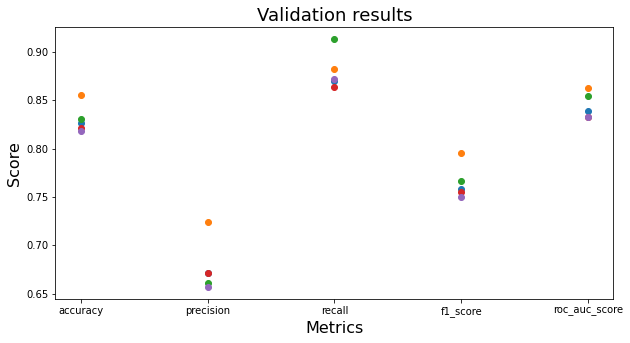

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(result_kf, marker='o', linestyle='None')
plt.title('Validation results', size=18)
plt.xlabel('Metrics', size=16)
plt.ylabel('Score', size=16);

Метрики не имеют большой дельты при переходе от одной части выборки для валидации к другой, что говорит об устойчивости предсказаний модели

#### Проверим качество на тестовой выборке, которую модель не видела до этого

In [55]:
table_q = []

for X, y in zip([X_train_new, X_val_new, X_test_new], [y_train, y_val, y_test]):
    y_pred_proba = meta_model.predict_proba(X)[:,1]
    y_pred = np.where(y_pred_proba > 0.2, 1, 0)
    
    a = accuracy_score(y, y_pred)
    p = precision_score(y, y_pred)
    r = recall_score(y, y_pred)
    f = f1_score(y, y_pred)
    ra = roc_auc_score(y, y_pred)
    table_q.append([a, p, r, f, ra])

In [56]:
pd.DataFrame(table_q, index=['Train', 'Validation', 'Test'], columns=metrics)

,accuracy,precision,recall,f1_score,roc_auc_score
Train,0.845857,0.694171,0.904805,0.785615,0.861956
Validation,0.837500,0.682987,0.894231,0.774462,0.853002
Test,0.824000,0.677885,0.870370,0.762162,0.836073


Таким образом, мы получили 87% метрику recall на отложенной тестовой выборке, что выше, чем в базовых моделях.

#### Проверим предсказания на соответствие здравому смыслу:

In [57]:
X_test_new['pred'] = y_pred

In [58]:
X_test_new.groupby('pred').mean()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,AGE_16-25,AGE_26-39,...,INCOME_middle class,INCOME_poverty,INCOME_upper class,INCOME_working class,VEHICLE_YEAR_before 2015,POSTAL_CODE_10238,POSTAL_CODE_21217,POSTAL_CODE_32765,POSTAL_CODE_92101,VEHICLE_TYPE_sports car
pred,,,,,,,,,,,,,,,,,,,,,
0,0.566658,0.839041,0.599315,0.828767,11277.397260,2.119863,0.332192,1.470890,0.020548,0.291096,...,0.239726,0.034247,0.609589,0.116438,0.523973,0.744863,0.000000,0.215753,0.039384,0.051370
1,0.453196,0.478365,0.286058,0.555288,12401.442308,0.487981,0.079327,0.266827,0.466346,0.350962,...,0.221154,0.379808,0.163462,0.235577,0.889423,0.600962,0.024038,0.293269,0.081731,0.052885


В соответствии с построенной моделью:
- человек, который имеет в среднем кредитный балл 0,45 скорее всего воспользуется страховкой, а вот с кредитным скором около 0, 56 страховку не будет использовать (то есть люди с большим достатком по оценке банка менее склоны попадать в аварии и использовать страховые выплаты);
- если человек владеет ТС, то он менее вероятно обратится за страховкой, нежели если оно, например, арендовано;
- люди, находящиеся в зарегестрированном браке и/или имеющие детей менее вероятно обратятся за страховкой;
- чем ниже годовой пробег, тем менее вероятно обращение за страховой выплатой;
- чем больше случаев превышения скорости и/или вождения в нетрезвом виде, тем менее вероятно обращение за страховой выплатой (так как это не страховой случай);
- если водитель попадал в аварию ранее, то он менее вероятно обратиться за выплатой, чем если окажется в аварии в первый раз;

В целом модель соответствует здравому смыслу и показывает высокое качество на метрике Recall, так как в страховом бизнесе важно определять все потенциальные страховые случаи, даже если они не произойдут

# Save model

### Testing for demo

In [59]:
#shap importance
import shap
booster = CatBoostClassifier(random_state=42, iterations=700, depth=6,  verbose=False)
booster.fit(X_train_new, y_train)
explainer = shap.Explainer(booster)
shap_values = explainer(X_val_new)

shap_feature_importance = dict(zip(shap_values.feature_names,
[round(x, 2)
 for x in shap_values.values[0].tolist()
]))

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

C extension was not built during install!
C extension was not built during install!


In [60]:
dict(sorted(shap_feature_importance.items(), key=lambda item: item[1]))

{'VEHICLE_YEAR_before 2015': -1.34,
 'DRIVING_EXPERIENCE_0-9y': -0.88,
 'POSTAL_CODE_10238': -0.6,
 'VEHICLE_OWNERSHIP': -0.54,
 'DRIVING_EXPERIENCE_20-29y': -0.43,
 'DRIVING_EXPERIENCE_10-19y': -0.17,
 'MARRIED': -0.13,
 'CREDIT_SCORE': -0.11,
 'INCOME_upper class': -0.11,
 'POSTAL_CODE_21217': -0.08,
 'AGE_26-39': -0.07,
 'POSTAL_CODE_32765': -0.07,
 'SPEEDING_VIOLATIONS': -0.06,
 'CHILDREN': -0.04,
 'AGE_16-25': -0.02,
 'INCOME_poverty': -0.02,
 'INCOME_working class': -0.02,
 'PAST_ACCIDENTS': -0.01,
 'AGE_40-64': -0.01,
 'EDUCATION_none': -0.01,
 'POSTAL_CODE_92101': -0.01,
 'VEHICLE_TYPE_sports car': -0.0,
 'AGE_65+': 0.03,
 'RACE_minority': 0.03,
 'EDUCATION_university': 0.03,
 'EDUCATION_high school': 0.04,
 'DUIS': 0.05,
 'INCOME_middle class': 0.05,
 'DRIVING_EXPERIENCE_30y+': 0.12,
 'ANNUAL_MILEAGE': 0.28,
 'GENDER_male': 0.63}

In [61]:
def meta_model_predict(x_my, booster):
    encode_features = ['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
                       'VEHICLE_YEAR', 'POSTAL_CODE', 'VEHICLE_TYPE']
    num_features = ['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'ANNUAL_MILEAGE',
                    'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']
    
    floats = {'ANNUAL_MILEAGE', 'CHILDREN', 'CREDIT_SCORE', 'MARRIED', 'VEHICLE_OWNERSHIP'}
    for f in floats:
        x_my[f] = x_my[f].astype(float)
    ints = {'DUIS', 'PAST_ACCIDENTS', 'POSTAL_CODE', 'SPEEDING_VIOLATIONS'}
    for i in ints:
        x_my[i] = x_my[i].astype(int)
    
    
    x_my_enc = encoder.transform(x_my[encode_features])
    x_my_enc = pd.DataFrame(x_my_enc, columns=encoder.get_feature_names(encode_features), index=x_my.index)

    x_my_new = pd.concat([x_my[num_features], x_my_enc], axis=1)
    
    pred = meta_model.predict_proba(x_my_new)[:,1]
    pred_class = np.where(pred > 0.2, 1, 0)
    
    
    import shap
    explainer = shap.Explainer(booster)
    shap_values = explainer(x_my_new)

    shap_feature_importance = dict(zip(shap_values.feature_names,
    [round(x, 2)
     for x in shap_values.values[0].tolist()
    ]))
    return pred_class[0], shap_feature_importance

In [62]:
# testing
x_example = pd.DataFrame(X_test.iloc[500]).T
meta_model_predict(x_example, booster)

C extension was not built during install!
C extension was not built during install!


(0,
 {'CREDIT_SCORE': -0.09,
  'VEHICLE_OWNERSHIP': -0.63,
  'MARRIED': -0.24,
  'CHILDREN': -0.06,
  'ANNUAL_MILEAGE': -0.12,
  'SPEEDING_VIOLATIONS': 0.21,
  'DUIS': 0.06,
  'PAST_ACCIDENTS': 0.18,
  'AGE_16-25': -0.02,
  'AGE_26-39': -0.02,
  'AGE_40-64': 0.01,
  'AGE_65+': 0.04,
  'GENDER_male': -0.72,
  'RACE_minority': 0.03,
  'DRIVING_EXPERIENCE_0-9y': 1.65,
  'DRIVING_EXPERIENCE_10-19y': -0.05,
  'DRIVING_EXPERIENCE_20-29y': 0.15,
  'DRIVING_EXPERIENCE_30y+': 0.1,
  'EDUCATION_high school': -0.0,
  'EDUCATION_none': -0.01,
  'EDUCATION_university': -0.06,
  'INCOME_middle class': 0.0,
  'INCOME_poverty': 0.02,
  'INCOME_upper class': -0.15,
  'INCOME_working class': -0.03,
  'VEHICLE_YEAR_before 2015': -1.57,
  'POSTAL_CODE_10238': -0.44,
  'POSTAL_CODE_21217': -0.07,
  'POSTAL_CODE_32765': -0.07,
  'POSTAL_CODE_92101': -0.01,
  'VEHICLE_TYPE_sports car': 0.02})

### Save

In [65]:
import dill
with open('./app/data_output/encoder.bin', 'wb') as f:
    dill.dump(encoder, f)
with open('./app/data_output/meta_model.bin', 'wb') as f:
    dill.dump(meta_model, f)
with open('./app/data_output/model.bin', 'wb') as f:
    dill.dump(meta_model_predict, f)
with open('./app/data_output/booster.bin', 'wb') as f:
    dill.dump(booster, f)